<a href="https://colab.research.google.com/github/Squirtle007/Noisy-Simulation-with-GPU-Acceleration/blob/main/%5BQiskit%5DBuilding_Noise_Models_gpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building Noise Models with GPU Acceleration**

Ref1: https://qiskit.github.io/qiskit-aer/tutorials/3_building_noise_models.html#Building-Noise-Models

Ref2: https://qiskit.github.io/qiskit-aer/howtos/running_gpu.html

In [114]:
!pip install qiskit-aer==0.14.0.1
!pip install qiskit-aer-gpu==0.14.0.1
!pip install qiskit==1.0.2

In [115]:
!pip install 'qiskit[visualization]'

In [116]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

In [117]:
# Construct a 1-qubit bit-flip and phase-flip errors
p_error = 0.05
bit_flip = pauli_error([('X', p_error), ('I', 1 - p_error)])
phase_flip = pauli_error([('Z', p_error), ('I', 1 - p_error)])
print(bit_flip)
print(phase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ X ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘
QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.05, Circuit = 
   ┌───┐
q: ┤ Z ├
   └───┘
  P(1) = 0.95, Circuit = 
   ┌───┐
q: ┤ I ├
   └───┘


In [118]:
# Compose two bit-flip and phase-flip errors
bitphase_flip = bit_flip.compose(phase_flip)
print(bitphase_flip)

QuantumError on 1 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ Z ├
   └───┘└───┘
  P(1) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ X ├┤ I ├
   └───┘└───┘
  P(2) = 0.0475, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ Z ├
   └───┘└───┘
  P(3) = 0.9025, Circuit = 
   ┌───┐┌───┐
q: ┤ I ├┤ I ├
   └───┘└───┘


In [119]:
# Tensor product two bit-flip and phase-flip errors with
# bit-flip on qubit-0, phase-flip on qubit-1
error2 = phase_flip.tensor(bit_flip)
print(error2)

QuantumError on 2 qubits. Noise circuits:
  P(0) = 0.0025000000000000005, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(1) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ Z ├
     └───┘
  P(2) = 0.0475, Circuit = 
     ┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ I ├
     └───┘
  P(3) = 0.9025, Circuit = 
     ┌───┐
q_0: ┤ I ├
     ├───┤
q_1: ┤ I ├
     └───┘


In [120]:
# Convert to Kraus operator
bit_flip_kraus = Kraus(bit_flip)
print(bit_flip_kraus)

Kraus([[[ 9.74679434e-01+0.j,  0.00000000e+00+0.j],
        [-1.20234617e-16+0.j,  9.74679434e-01+0.j]],

       [[ 2.62045272e-16+0.j,  2.23606798e-01+0.j],
        [ 2.23606798e-01+0.j, -2.84112242e-16+0.j]]],
      input_dims=(2,), output_dims=(2,))


In [121]:
# Convert to Superoperator
phase_flip_sop = SuperOp(phase_flip)
print(phase_flip_sop)

SuperOp([[1. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0.9+0.j, 0. +0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0.9+0.j, 0. +0.j],
         [0. +0.j, 0. +0.j, 0. +0.j, 1. +0.j]],
        input_dims=(2,), output_dims=(2,))


In [122]:
# Convert back to a quantum error
print(QuantumError(bit_flip_kraus))

# Check conversion is equivalent to original error
QuantumError(bit_flip_kraus) == bit_flip

QuantumError on 1 qubits. Noise circuits:
  P(0) = 1.0, Circuit = 
   ┌───────┐
q: ┤ kraus ├
   └───────┘


True

In [123]:
# Measurement miss-assignement probabilities
p0given1 = 0.1
p1given0 = 0.05

ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

ReadoutError([[0.95 0.05]
 [0.1  0.9 ]])

In [124]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [125]:
# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ['u1', 'u2', 'u3'], [0])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u1', 'u2']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


In [126]:
# System Specification
n_qubits = 5
circ = QuantumCircuit(n_qubits)

# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                     ░ ┌─┐            
   q_0: ┤ H ├──■──────────────────░─┤M├────────────
        └───┘┌─┴─┐                ░ └╥┘┌─┐         
   q_1: ─────┤ X ├──■─────────────░──╫─┤M├─────────
             └───┘┌─┴─┐           ░  ║ └╥┘┌─┐      
   q_2: ──────────┤ X ├──■────────░──╫──╫─┤M├──────
                  └───┘┌─┴─┐      ░  ║  ║ └╥┘┌─┐   
   q_3: ───────────────┤ X ├──■───░──╫──╫──╫─┤M├───
                       └───┘┌─┴─┐ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ────────────────────┤ X ├─░──╫──╫──╫──╫─┤M├
                            └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════╩══╩══╩══╩══╩═
                                     0  1  2  3  4 


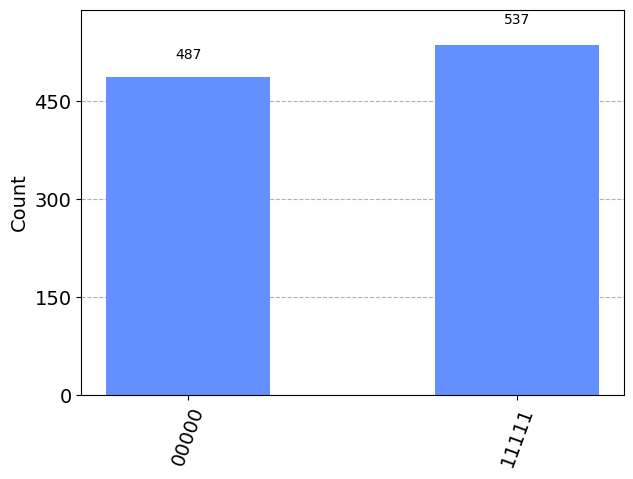

In [127]:
# Ideal simulator and execution
sim_ideal = AerSimulator(device='GPU')
result_ideal = sim_ideal.run(circ).result()
plot_histogram(result_ideal.get_counts(0))

In [128]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u2', 'reset', 'u3', 'cx', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


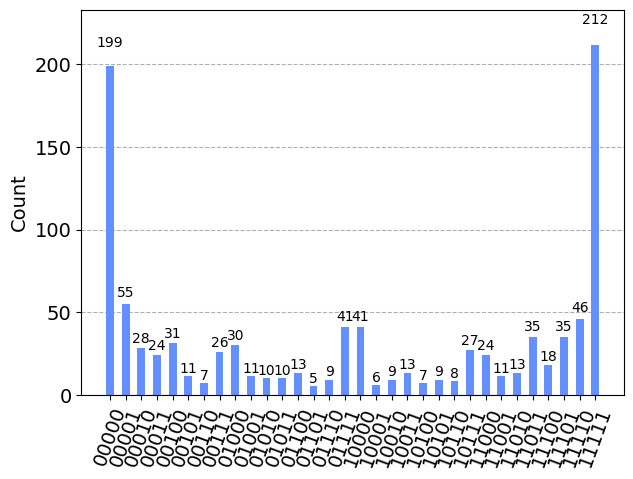

In [129]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip, device='GPU')

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(circ, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)